# Using LIME to Explore Image Predictions

## Importing dependencies

In [1]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense
import numpy as np
import random
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Increasing font size for matplotlib plots
plt.rcParams.update({'font.size': 18})

## Training a convolutional neural network

In [2]:
# Loading the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Adding a channel dimension to the images
train_images = np.expand_dims(a=train_images, axis=-1) / 255.0
test_images = np.expand_dims(a=test_images, axis=-1) / 255.0

# Converting grayscale images to RGB
train_images = tf.image.grayscale_to_rgb(images=tf.convert_to_tensor(train_images))
test_images = tf.image.grayscale_to_rgb(images=tf.convert_to_tensor(test_images))

# Obtaining possible labels from the dataset
labels_to_explain = np.unique(ar=test_labels)

# Converting labels to categoricals
train_labels = tf.keras.utils.to_categorical(y=train_labels)
test_labels = tf.keras.utils.to_categorical(y=test_labels)

In [3]:
# Function for creating TF Keras model
def create_model():
    # Input layer
    input_layer = Input(shape=(28, 28, 3))

    # First Conv2D + MaxPool2D block
    x = Conv2D(filters=16,
               kernel_size=(3, 3),
               activation="relu",
               padding="same")(input_layer)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second Conv2D + MaxPool2D block
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               activation="relu",
               padding="same")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    # Third Conv2D + MaxPool2D block
    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation="relu",
               padding="same")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Global Average Pooling and Dense output layers
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(units=10, 
                         activation="softmax")(x)

    # Returning the model
    return Model(inputs=input_layer, 
                 outputs=output_layer)

In [4]:
# Creating the model
model = create_model()

# Compiling the model
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Training the model
history = model.fit(x=train_images, y=train_labels,
                    batch_size=128,
                    epochs=5,
                    validation_data=(test_images, test_labels))

Epoch 1/5
469/469 [==============================] - 6s 8ms/step - loss: 0.5595 - accuracy: 0.8304 - val_loss: 0.1969 - val_accuracy: 0.9434
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1758 - accuracy: 0.9489 - val_loss: 0.1395 - val_accuracy: 0.9569
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1296 - accuracy: 0.9614 - val_loss: 0.0991 - val_accuracy: 0.9688
Epoch 4/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1023 - accuracy: 0.9689 - val_loss: 0.0933 - val_accuracy: 0.9725
Epoch 5/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0870 - accuracy: 0.9732 - val_loss: 0.0665 - val_accuracy: 0.9801


In [5]:
# Saving our model
model.save(filepath="model.h5")

In [6]:
# Loading a saved model
#model = create_model()
#model.load_weights(filepath="model.h5")

## Using LIME to explain model predictions

In [7]:
# Creating a list for image indices
indices = []

# Obtaining the index of the first image of each label
for label in labels_to_explain:
    label_index = np.where(np.argmax(a=test_labels, axis=1)==label)[0][0]    
    indices.append(label_index)

# Converting Tensor images to NumPy
test_images = test_images.numpy()

# Getting the images of the ten digits
imgs_to_explain = test_images[indices]

In [8]:
# Creating an explainer
explainer = lime_image.LimeImageExplainer(random_state=5)

In [9]:
# Creating a segmenter
segmenter = SegmentationAlgorithm(algo_type="quickshift",                                 
                                  kernel_size=1, 
                                  max_dist=2)

In [10]:
# Explaining an image instance, obtaining the top 10 predictions for it
explanation = explainer.explain_instance(image=imgs_to_explain[1],
                                         classifier_fn=model.predict,
                                         top_labels=10,
                                         num_samples=500,                                         
                                         segmentation_fn=segmenter,
                                         random_seed=5)       

  0%|          | 0/500 [00:00<?, ?it/s]

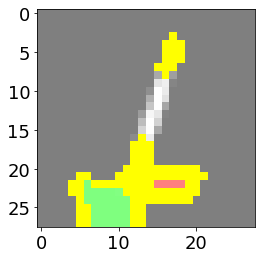

In [11]:
# Getting the image heatmap and the mask
temp, mask = explanation.get_image_and_mask(label=labels_to_explain[1], 
                                            positive_only=False,
                                            negative_only=False,
                                            hide_rest=False)
    
    
# Showing the image with the superimposed mask
plt.imshow(mark_boundaries(image=temp / 2 + 0.5, label_img=mask))

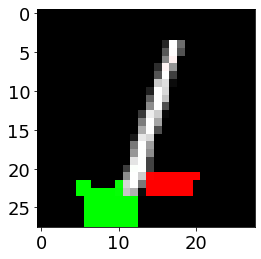

In [12]:
# Inspecting the image with a heatmap
plt.imshow(temp)

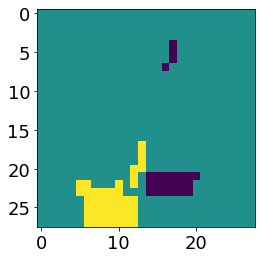

In [13]:
# Inspecting the mask
plt.imshow(mask)

## Exploring the capabilities of image explanations in LIME

### Creating a segmenter

In [14]:
# Function for creating a segmenter
def create_segmenter(**kwargs):       
    # Returning an instantiated segmenter
    return SegmentationAlgorithm(**kwargs)

### Handling explanation generation and plotting

In [15]:
# Class for making explanations
class Explainer():
    # Class constructor
    def __init__(self,
                 imgs_to_explain):
        self.imgs_to_explain = imgs_to_explain
        self.explanations =  []
    
    # Function for explaining instances
    def explain_instances(self,
                          classifier_fn,
                          top_labels,
                          num_samples,
                          segmentation_fn,
                          random_seed):        
        
        # Emptying the explanation list in case
        # explanations have been generated before
        self.explanations =  []
        
        # Iterating over the images
        for i in range(len(self.imgs_to_explain)):
            # Explaining an image of each digit and saving the explainer
            self.explanations.append(explainer.explain_instance(image=self.imgs_to_explain[i],
                                                                classifier_fn=classifier_fn,
                                                                top_labels=top_labels,
                                                                num_samples=num_samples,
                                                                segmentation_fn=segmentation_fn,
                                                                random_seed=random_seed))
    
    # Function for plotting explanations
    def plot_explanations(self,
                          rows,
                          cols,
                          image_indices,
                          top_predictions,
                          positive_only=True,
                          negative_only=False,
                          hide_rest=False):
                      
        # Creating a figure and subplots
        # We are adding 1 to cols to get a spot for the source image
        fig, ax = plt.subplots(rows, cols + 1, squeeze=False)
        fig.set_size_inches(4 * cols, 3 * rows)
        
        # Iterating over the provided image indices        
        for i in range(len(image_indices)):           
            # Getting the explanation for the supplied image index
            explanation = self.explanations[image_indices[i]]
            
            # Showing the source image in the leftmost column
            ax[i, 0].imshow(self.imgs_to_explain[i])
            
            # Hiding x and y ticks
            ax[i, 0].set_xticks(ticks=[])
            ax[i, 0].set_yticks(ticks=[])
            
            # Iterating over the top predicted labels
            # We are starting j from 1 and going 1 over top_predictions because we need
            # to plot after the source image
            for j in range(1, top_predictions + 1):       
                # Generating the image heatmap and the mask
                # We are subtracting 1 from j because
                # j starts from 1, whereas top_labels starts from 0
                temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[j - 1],
                                                            positive_only=positive_only,
                                                            negative_only=negative_only,
                                                            hide_rest=hide_rest)                              
                
                # Plotting the explanation for the current top_label
                ax[i, j].imshow(mark_boundaries(temp / 2 + 0.5, mask))

                # Showing the prediction corresponding to explanation
                ax[i, j].set_title(label=f"Prediction: {explanation.top_labels[j - 1]}")                
                
                # Hiding x and y ticks
                ax[i, j].set_xticks(ticks=[])
                ax[i, j].set_yticks(ticks=[])  

        # Using the space available in the figure efficiently
        plt.tight_layout()
        
        # Showing the plot
        plt.show()
        
    def plot_explanations_for_single_image(self,
                                           rows,
                                           cols,
                                           image_index,
                                           labels,
                                           positive_only=True,
                                           negative_only=False,
                                           hide_rest=False):
        
        # Creating a figure for the explanations
        plt.figure(figsize=(3 * cols, 3 * rows))
        
        # Getting the explanation for the supplied image index
        explanation = self.explanations[image_index]
        
        # Iterating over the total number of spots in the figure
        for i in range(rows * cols):
            # Creating a subplot
            plt.subplot(rows, cols, i + 1)    
            
            # Generating the processed image and mask
            temp, mask = explanation.get_image_and_mask(label=labels[i],
                                                        positive_only=positive_only,
                                                        negative_only=negative_only,
                                                        hide_rest=hide_rest)
            
            # Plotting the explanation for the current label
            plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
            
            # Showing the label that the image was explained for
            plt.title(label=f"Label: {labels[i]}")

            # Hiding x and y ticks
            plt.xticks(ticks=[])
            plt.yticks(ticks=[])  

        # Using space available in the figure efficiently
        plt.tight_layout()

        # Showing the plot
        plt.show()

### Generating explanations with quickshift

In [16]:
# Creating a quickshift segmenter
segmenter_quickshift = create_segmenter(algo_type="quickshift", 
                                        kernel_size=1, 
                                        max_dist=2, 
                                        random_seed=5)

# Creating an Explainer object
my_explainer = Explainer(imgs_to_explain)

In [17]:
# Explaining provided instances
my_explainer.explain_instances(classifier_fn=model.predict,                                  
                               top_labels=10,
                               num_samples=1000,
                               segmentation_fn=segmenter_quickshift,
                               random_seed=5)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

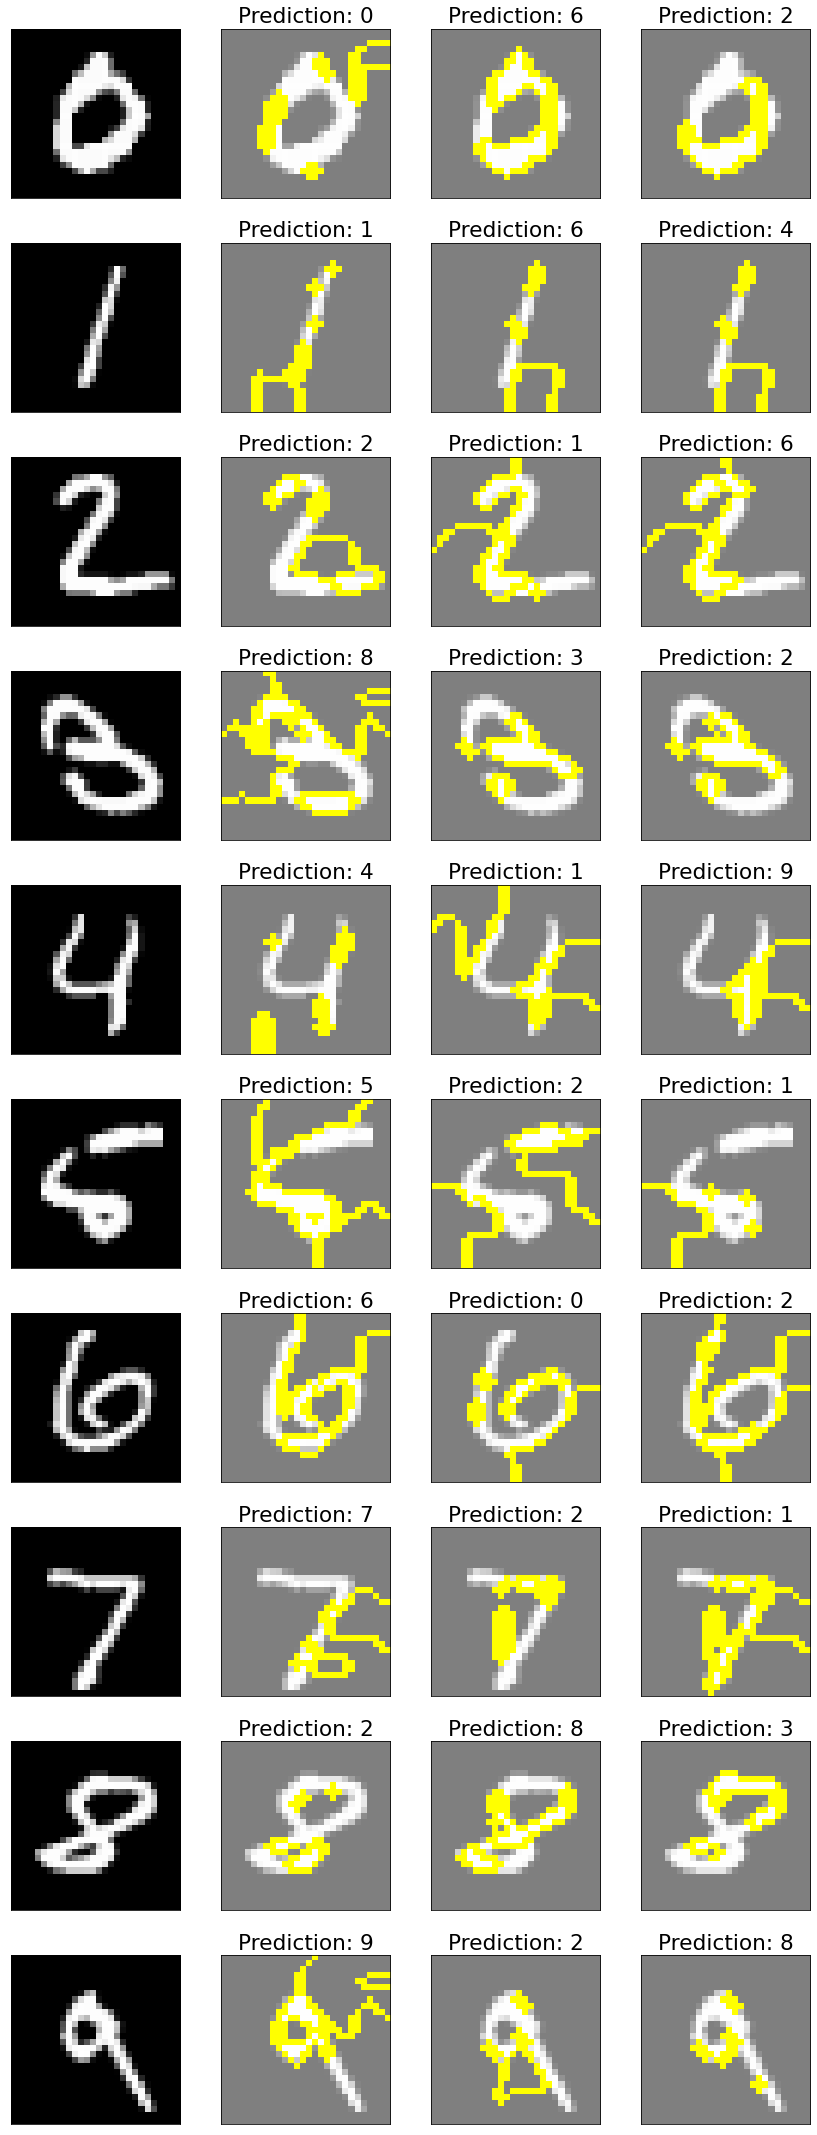

In [18]:
# Plotting explanations for ten digits, highlighting positive areas
my_explainer.plot_explanations(rows=10,
                               cols=3,
                               image_indices=list(range(10)),
                               top_predictions=3)

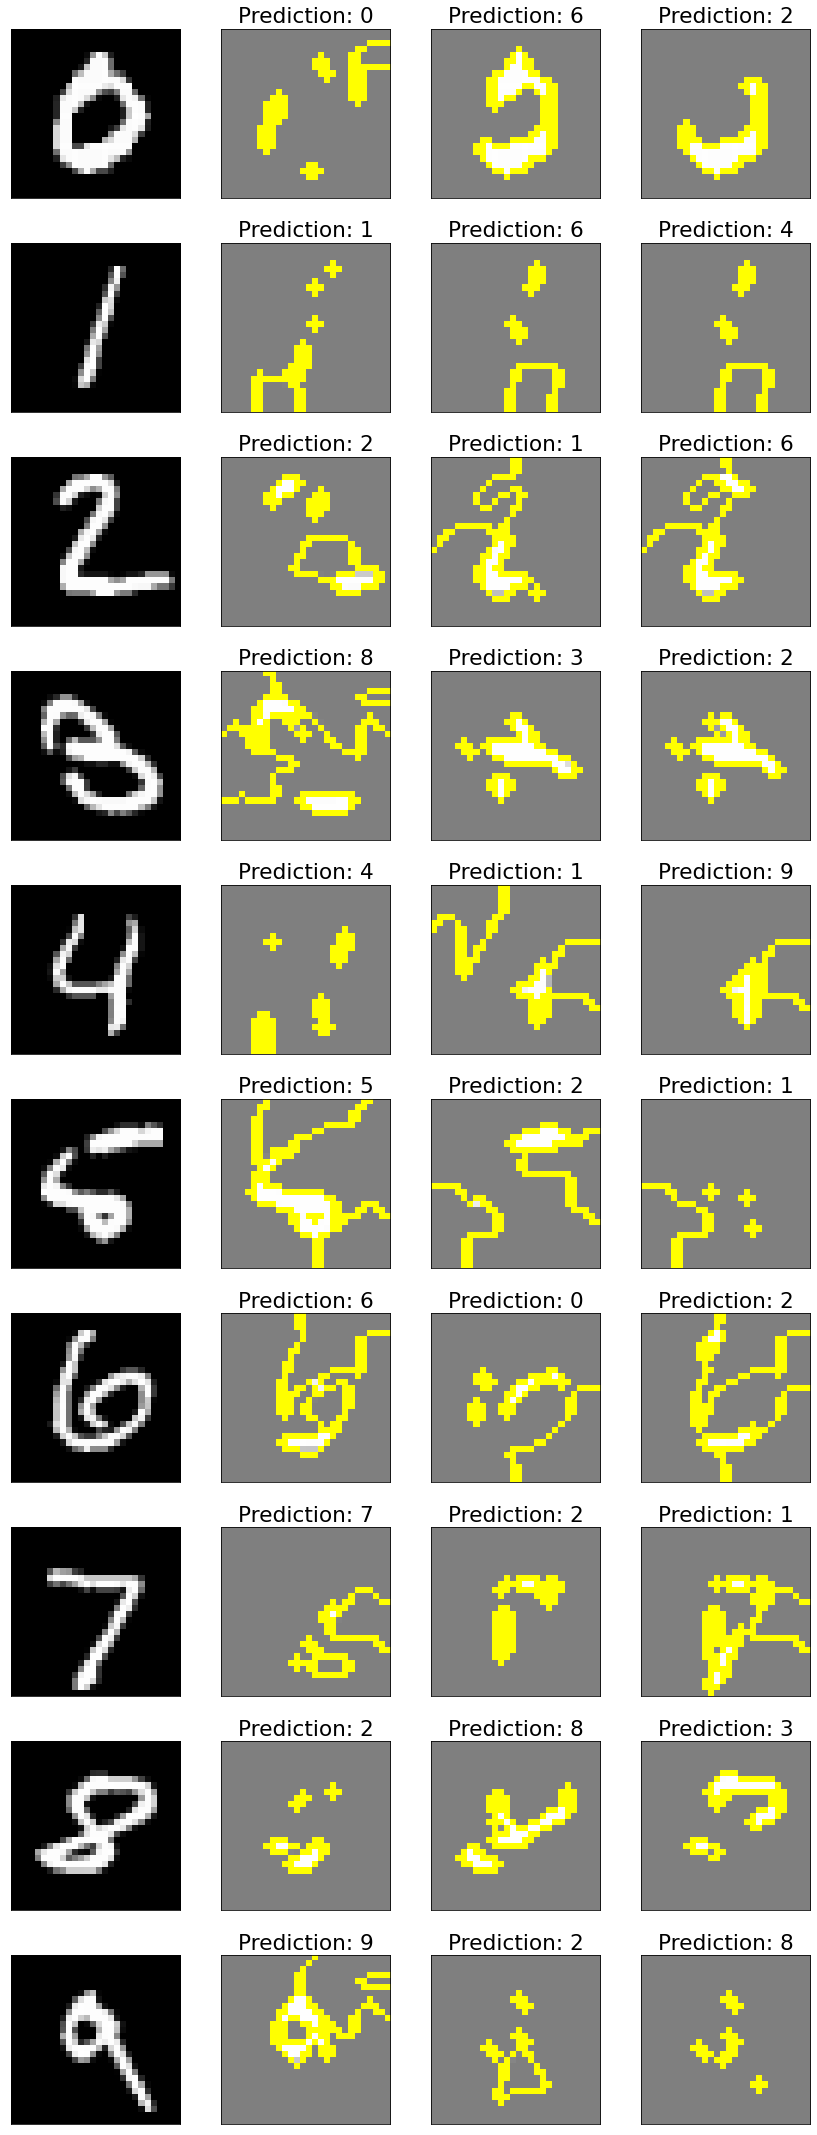

In [19]:
# Plotting explanations for ten digits, showing only positive areas
my_explainer.plot_explanations(rows=10,
                               cols=3,
                               image_indices=list(range(10)),
                               top_predictions=3,
                               hide_rest=True)

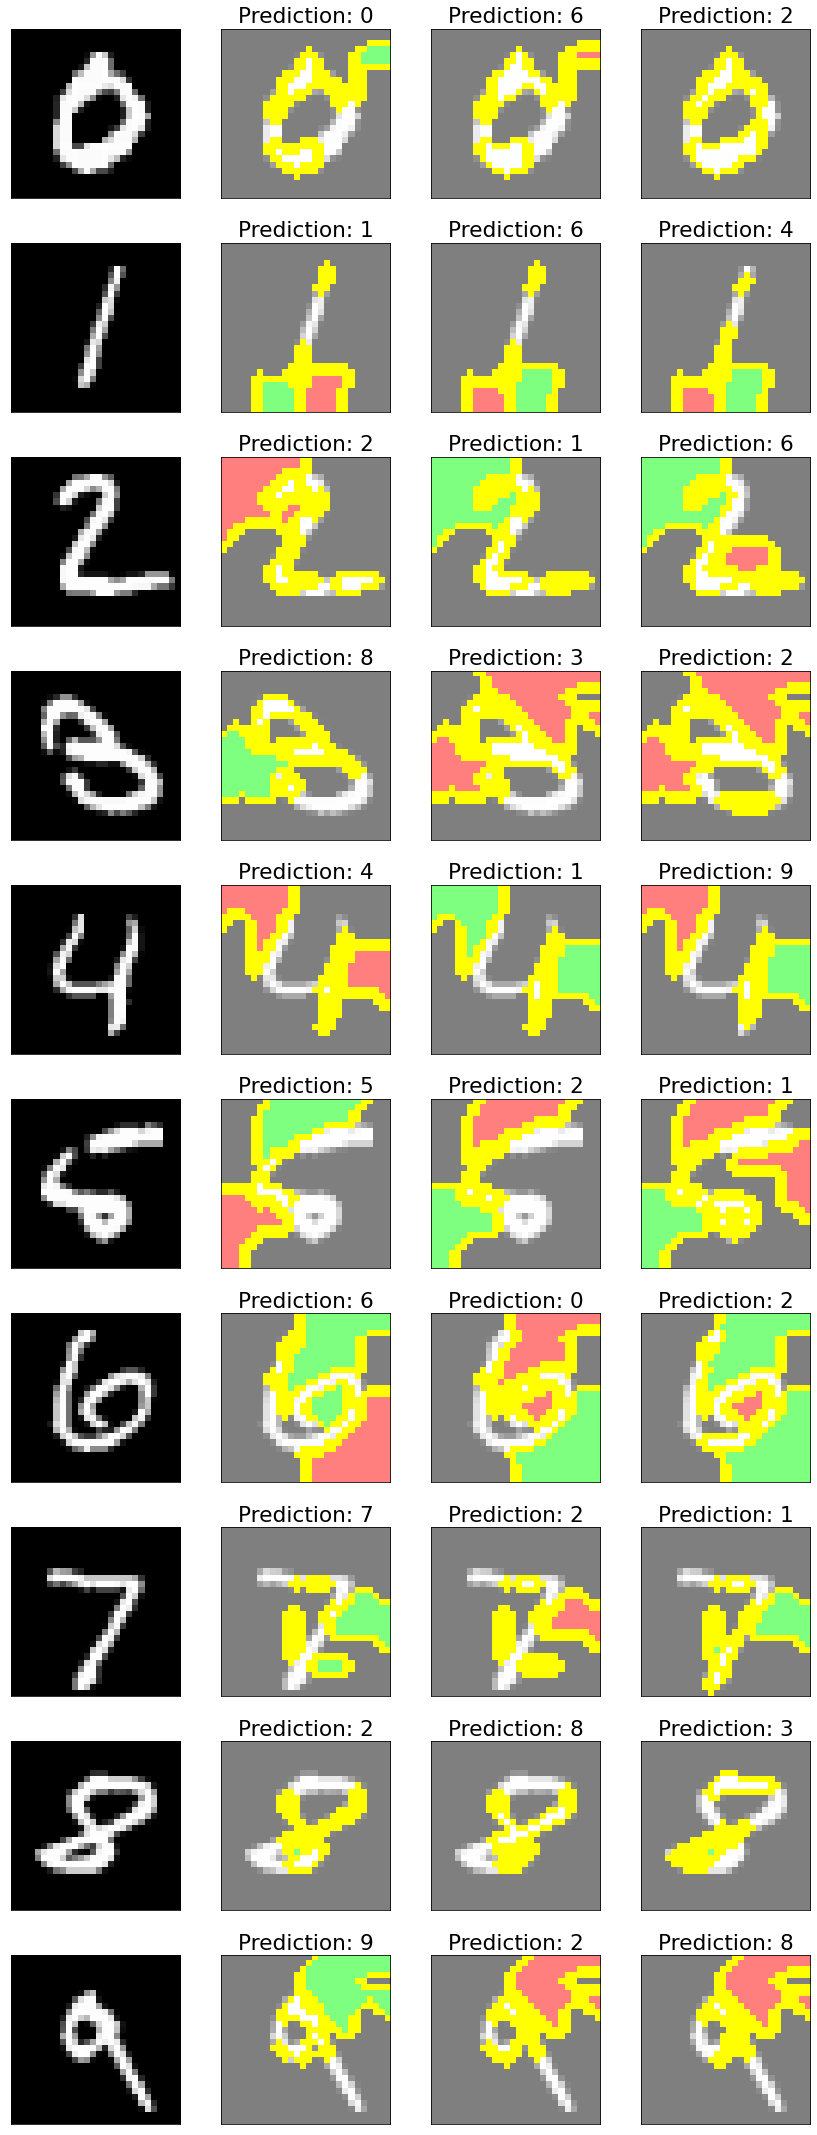

In [20]:
# Plotting explanations for ten digits, showing positive and negative areas
my_explainer.plot_explanations(rows=10,
                               cols=3,
                               image_indices=list(range(10)),
                               top_predictions=3,
                               positive_only=False)

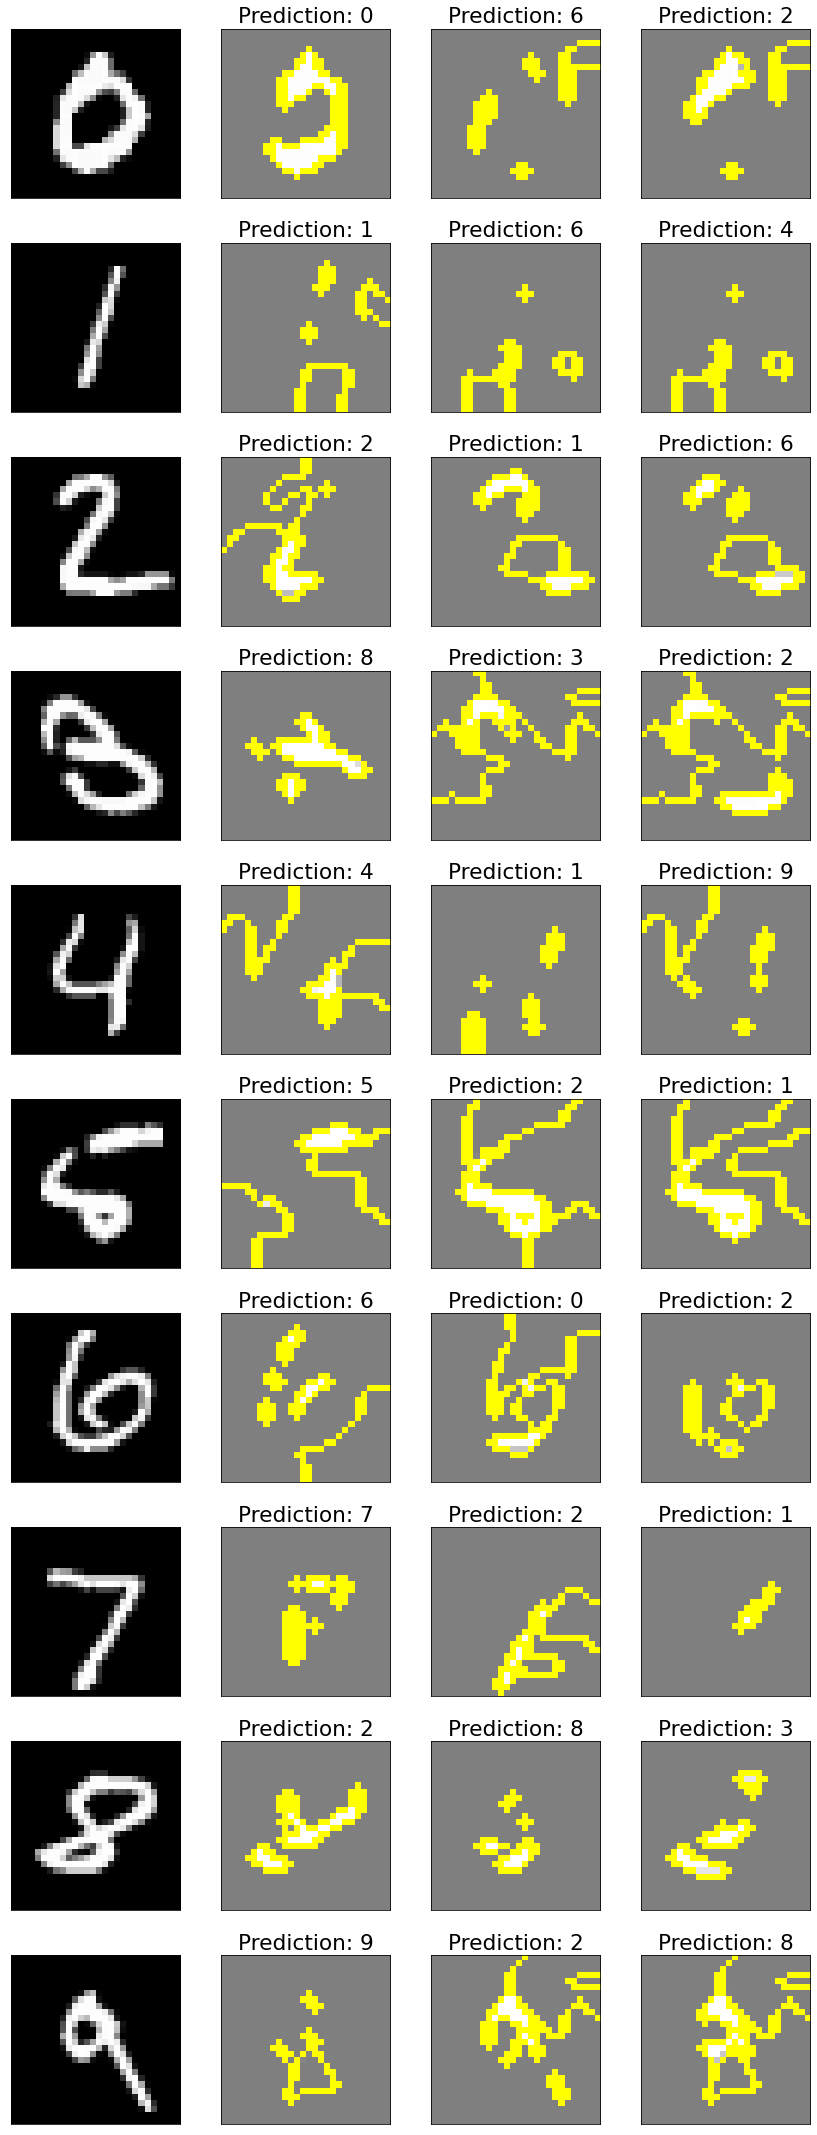

In [21]:
# Plotting explanations for ten digits, showing only negative areas
my_explainer.plot_explanations(rows=10,
                               cols=3,
                               image_indices=list(range(10)),
                               top_predictions=3,
                               positive_only=False,
                               negative_only=True,
                               hide_rest=True)

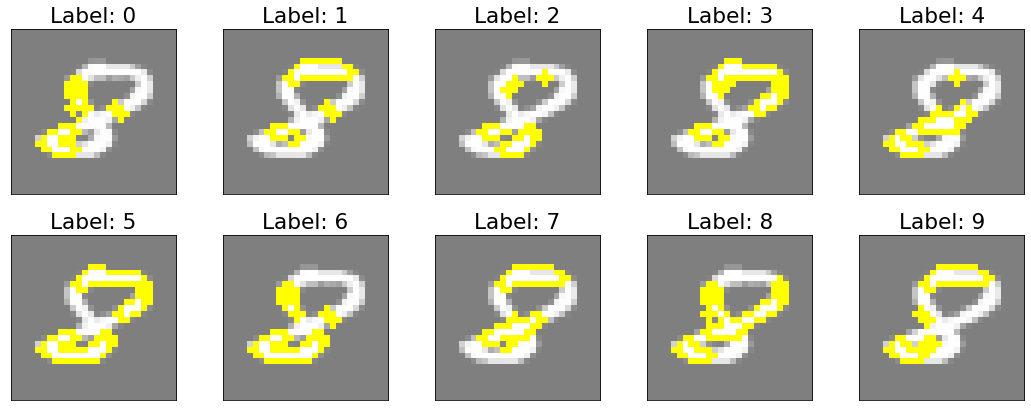

In [22]:
# Plotting explanations for the digit 8, highlighting positive areas
my_explainer.plot_explanations_for_single_image(rows=2,
                                                cols=5,
                                                image_index=8,
                                                labels=labels_to_explain)

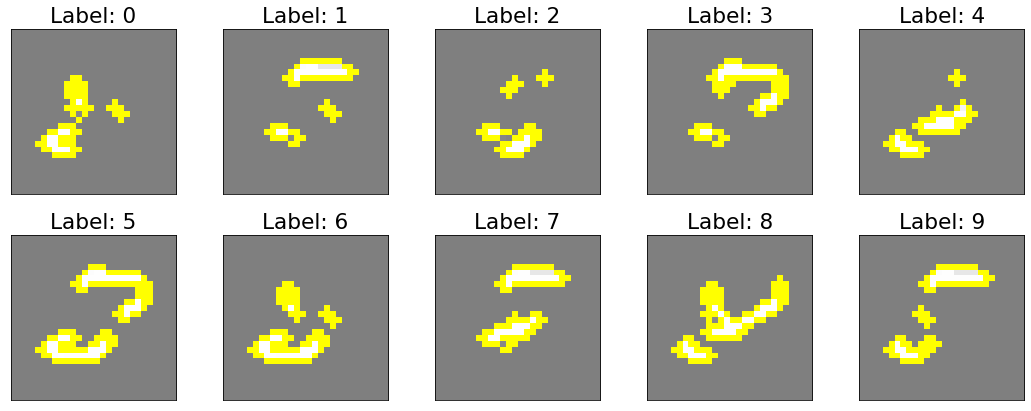

In [23]:
# Plotting explanations for the digit 8, showing only positive areas
my_explainer.plot_explanations_for_single_image(rows=2,
                                                cols=5,
                                                image_index=8,
                                                labels=labels_to_explain,
                                                hide_rest=True)

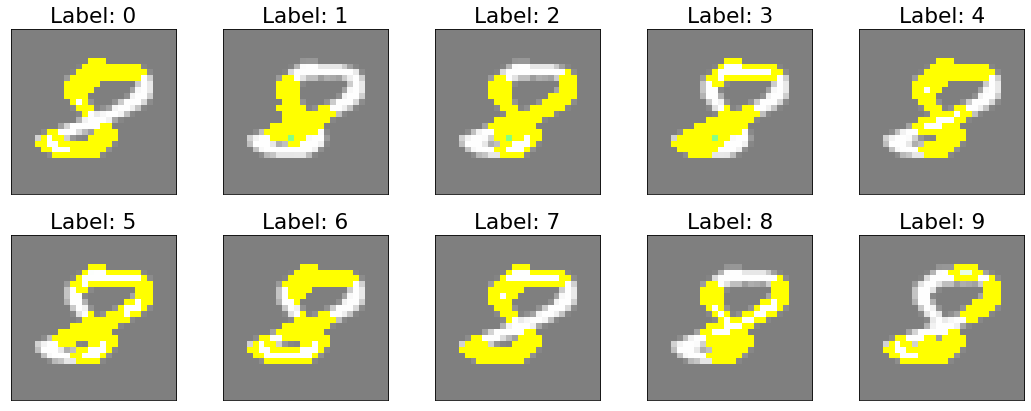

In [24]:
# Plotting explanations for the digit 8, showing positive and negative areas
my_explainer.plot_explanations_for_single_image(rows=2,                                               
                                                cols=5,
                                                image_index=8,
                                                labels=labels_to_explain,
                                                positive_only=False)

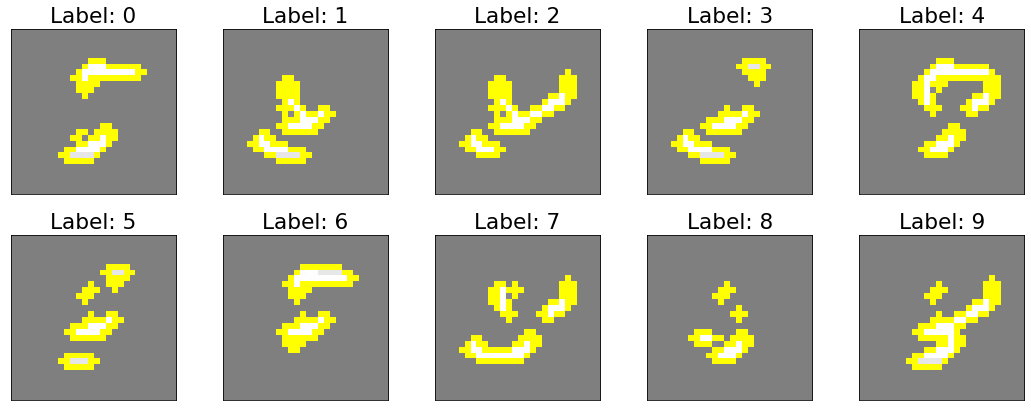

In [25]:
# Plotting explanations for the digit 8, showing only negative areas
my_explainer.plot_explanations_for_single_image(rows=2,
                                                cols=5,
                                                image_index=8,
                                                labels=labels_to_explain,
                                                positive_only=False,
                                                negative_only=True,
                                                hide_rest=True)

### Generating explanations with felzenszwalb and slic

In [26]:
# Creating a Felzenszwalb segmenter
segmenter_felzenszwalb = create_segmenter(algo_type="felzenszwalb",
                                          scale=1,
                                          sigma=0.8,
                                          min_size=5,
                                          random_seed=5)

# Explaining provided instances
my_explainer.explain_instances(classifier_fn=model.predict,
                               top_labels=10,
                               num_samples=1000,
                               segmentation_fn=segmenter_felzenszwalb,
                               random_seed=5)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

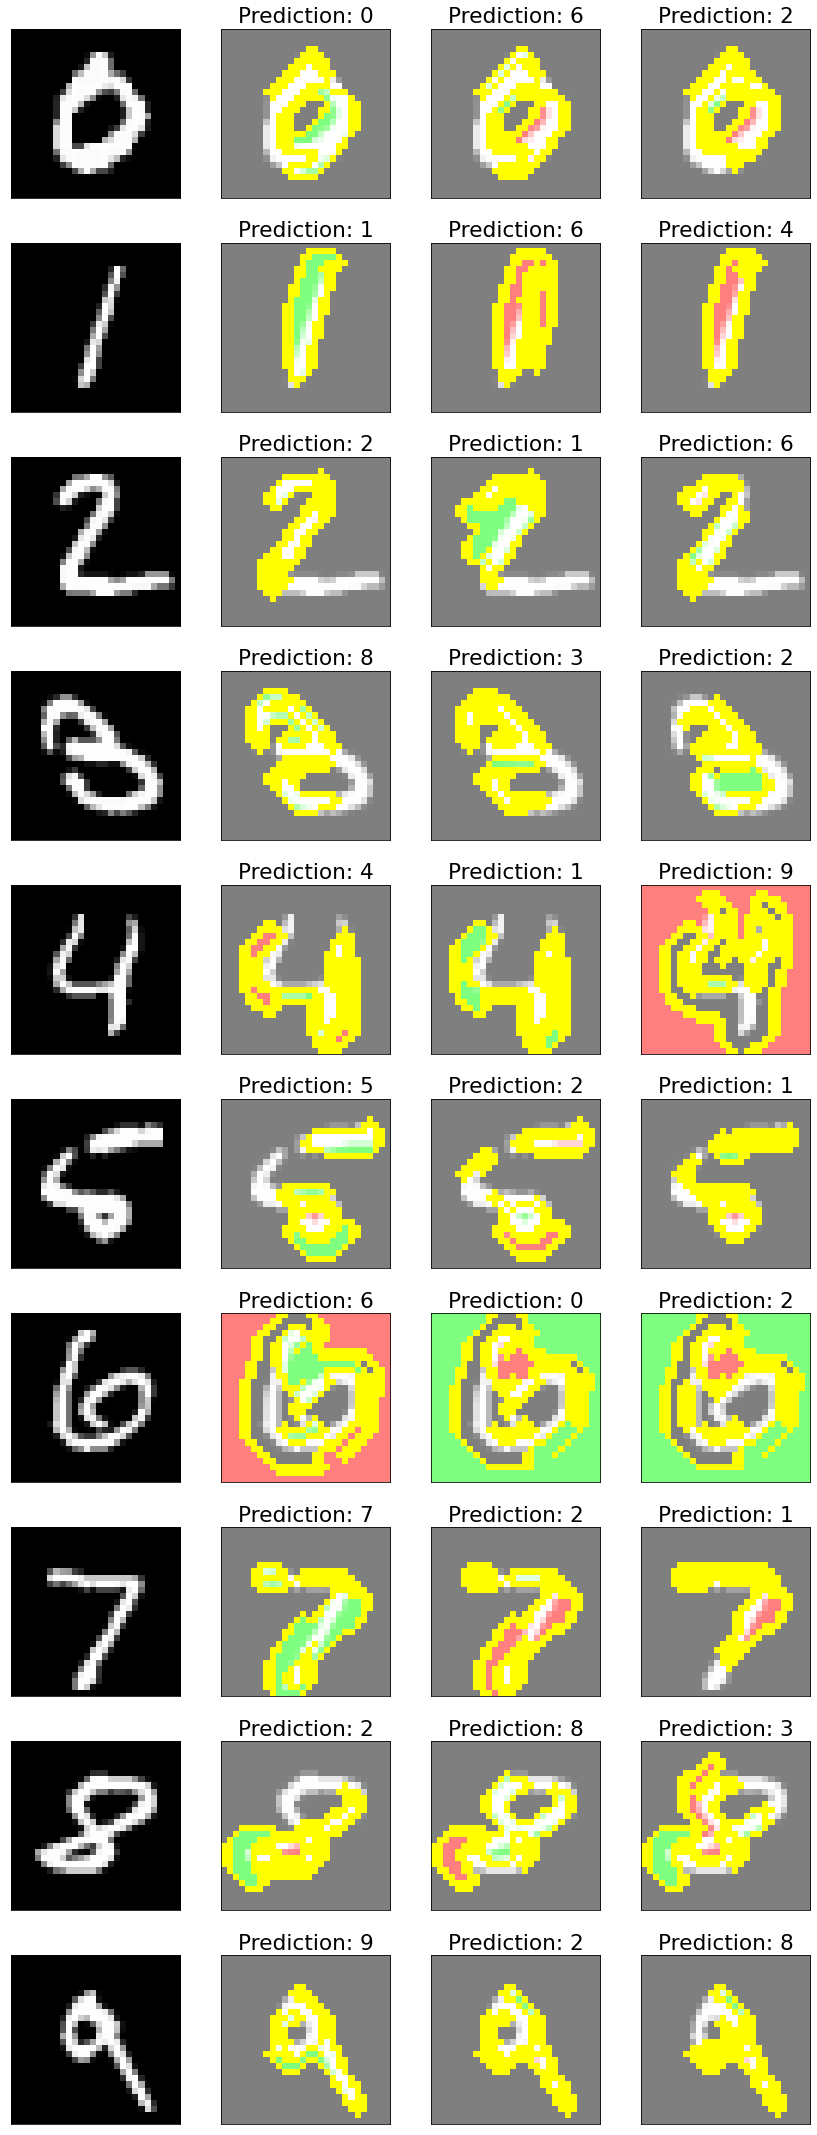

In [27]:
# Plotting explanations for ten digits, showing positive and negative areas
my_explainer.plot_explanations(rows=10,
                               cols=3,
                               image_indices=list(range(10)),
                               top_predictions=3,
                               positive_only=False)

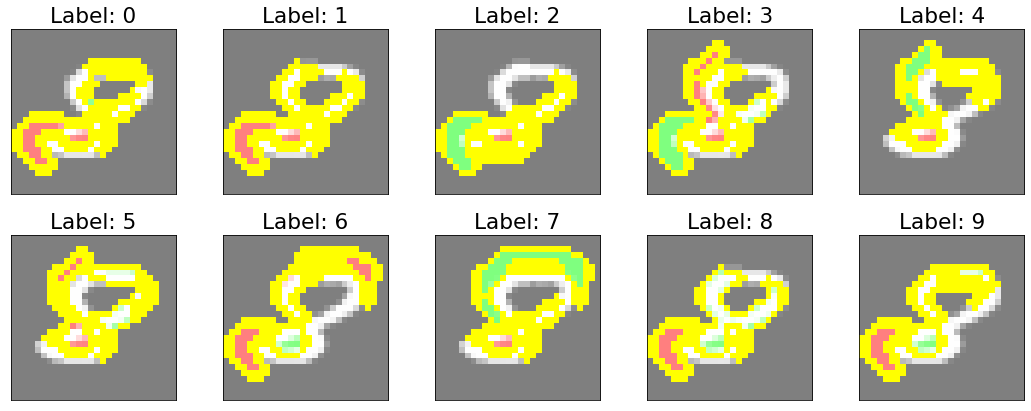

In [28]:
# Plotting explanations for the digit 8, showing positive and negative areas
my_explainer.plot_explanations_for_single_image(rows=2,
                                                cols=5,
                                                image_index=8,
                                                labels=labels_to_explain,
                                                positive_only=False)

In [29]:
# Creating a slic segmenter
segmenter_slic = create_segmenter(algo_type="slic",
                                  n_segments=100,
                                  random_seed=5)

# Explaining provided instances
my_explainer.explain_instances(classifier_fn=model.predict,
                               top_labels=10,
                               num_samples=1000,                               
                               segmentation_fn=segmenter_slic,
                               random_seed=5)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

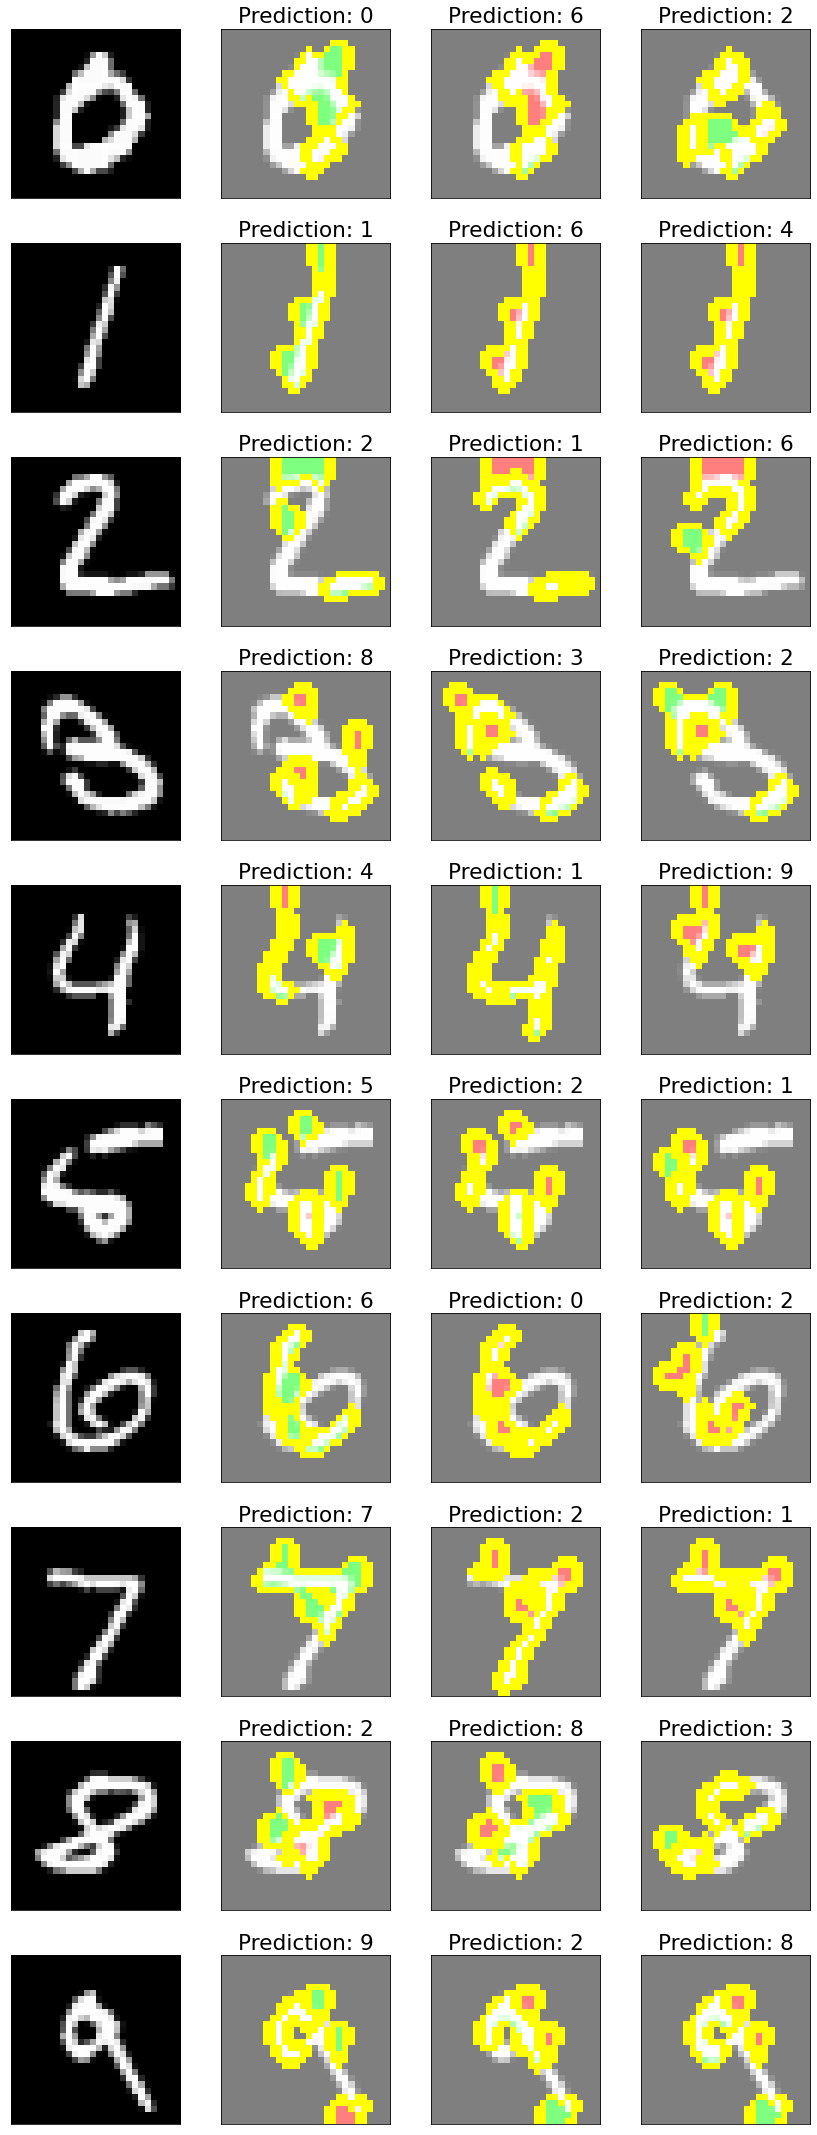

In [30]:
# Plotting explanations for ten digits, showing positive and negative areas
my_explainer.plot_explanations(rows=10,
                               cols=3,
                               image_indices=list(range(10)),
                               top_predictions=3,
                               positive_only=False)

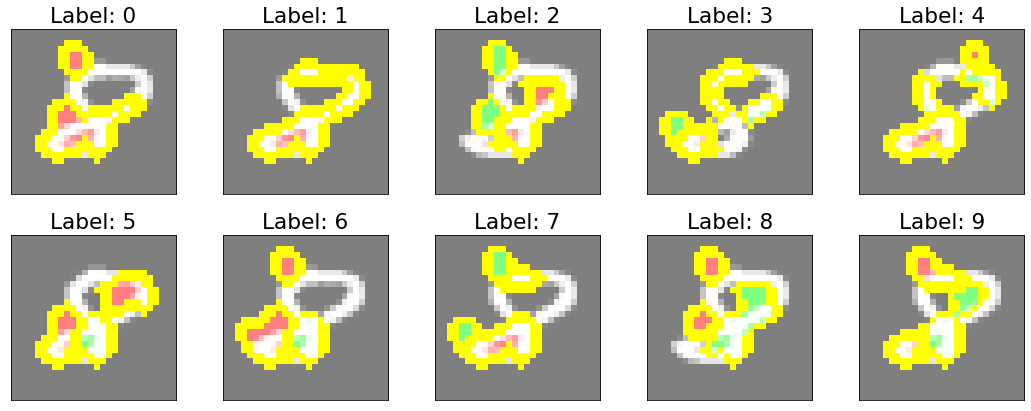

In [31]:
# Plotting explanations for the digit 8, showing positive and negative areas
my_explainer.plot_explanations_for_single_image(rows=2,
                                                cols=5,
                                                image_index=8,
                                                labels=labels_to_explain,
                                                positive_only=False)